# Emotion-Recognition kaggle Model V1

## Intro

We will now create a model to be trained on the Kaggle dataset since it contains more data than CK+.

## Hardware Information and GPU Support

Let's start by checking if Tesorflow is correctly detecting and using the GPU.

In [17]:
# You could later create a helper file where you add these functions and modules
import psutil as ps
import GPUtil as gpx
import platform
from tabulate import tabulate
from datetime import datetime
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dense, Input, Dropout,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
from keras.models import model_from_yaml
%matplotlib inline

# Simple helper function to scale to higher values
def get_size(bytes, suffix="B"):
    """
    Scale bytes to its proper format
    e.g:
        1253656 => '1.20MB'
        1253656678 => '1.17GB'
    """
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor


# First let's define a function to display the system's information
def print_system_info():
    # System Info
    print("="*20, "System Information", "="*20)
    uname = platform.uname()
    print(f"System: {uname.system}")
    print(f"Release: {uname.release}")
    print(f"Processor: {uname.machine}")

    print("\n")

    # CPU Info
    # let's print CPU information
    print("="*25, "CPU Info", "="*25)
    # number of cores
    print("Physical cores:", ps.cpu_count(logical=False))
    print("Total cores:", ps.cpu_count(logical=True))
    # CPU frequencies
    cpufreq = ps.cpu_freq()
    print(f"Current Frequency: {cpufreq.current:.2f}Mhz")

    print("\n")

    # Memory Information
    print("="*20, "Memory Information", "="*20)
    # get the memory details
    svmem = ps.virtual_memory()
    print(f"Total: {get_size(svmem.total)}")
    print(f"Available: {get_size(svmem.available)}")
    print(f"Used: {get_size(svmem.used)}")
    print(f"Percentage: {svmem.percent}%")
    
    print("\n")
    
    # Swap Information
    print("="*27, "SWAP", "="*27)
    swap = ps.swap_memory()
    print(f"Total: {get_size(swap.total)}")
    print(f"Free: {get_size(swap.free)}")
    print(f"Used: {get_size(swap.used)}")
    print(f"Percentage: {swap.percent}%")

    print("\n")

    # Disk Information
    print("="*21, "Disk Information", "="*21)
    print("Partitions and Usage:")
    partitions = ps.disk_partitions()
    # I want only to get the information about the main SSD where Windows is installed
    print(f"=== Device: {partitions[0].device} ===")
    print(f"  Mountpoint: {partitions[0].mountpoint}")
    print(f"  File system type: {partitions[0].fstype}")
    partition_usage = ps.disk_usage(partitions[0].mountpoint)
    print(f"  Total Size: {get_size(partition_usage.total)}")
    print(f"  Used: {get_size(partition_usage.used)}")
    print(f"  Free: {get_size(partition_usage.free)}")
    print(f"  Percentage: {partition_usage.percent}%")

    print("\n")

    # GPU Information
    print("="*24, "GPU Details", "="*24)
    gpus = gpx.getGPUs()
    list_gpus = []
    for gpu in gpus:
        # name of GPU
        gpu_name = gpu.name
        # get % percentage of GPU usage of that GPU
        gpu_load = f"{gpu.load*100}%"

        gpu_free_memory = f"{round(gpu.memoryFree/1024,2)}GB"
        gpu_used_memory = f"{round(gpu.memoryUsed/1024,2)}GB"
        gpu_total_memory = f"{round(gpu.memoryTotal/1024,2)}GB"
        gpu_temperature = f"{gpu.temperature} °C"
        list_gpus.append((
            gpu_name, gpu_free_memory, gpu_used_memory,
            gpu_total_memory, gpu_temperature
        ))
    print(tabulate(list_gpus, headers=("Name", "Free VRAM", "Used VRAM", "Total VRAM", "Temperature")))
    print("\n")



# Function top check if tensorflow is installed and if it is detecting the GPU correctly
def tensorflow_gpu_check():
    print("="*24, "Tensorflow", "="*24)
    print("Version: ", tf.__version__)
    print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


print_system_info()
tensorflow_gpu_check()

==================== System Information ====================
System: Windows
Release: 10
Processor: AMD64


========================= CPU Info =========================
Physical cores: 16
Total cores: 32
Current Frequency: 3401.00Mhz


==================== Memory Information ====================
Total: 63.95GB
Available: 52.58GB
Used: 11.36GB
Percentage: 17.8%


=========================== SWAP ===========================
Total: 76.36GB
Free: 31.77GB
Used: 44.59GB
Percentage: 58.4%


===================== Disk Information =====================
Partitions and Usage:
=== Device: C:\ ===
  Mountpoint: C:\
  File system type: NTFS
  Total Size: 1.82TB
  Used: 236.46GB
  Free: 1.59TB
  Percentage: 12.7%


======================== GPU Details ========================
Name                     Free VRAM    Used VRAM    Total VRAM    Temperature
-----------------------  -----------  -----------  ------------  -------------
NVIDIA GeForce RTX 3090  1.56GB       22.44GB      24.0GB        36.0 °C

## Dataset
The kaggle dataset has no 'contempt' emotion in it, but it has a 'neutral' class.

- Angry
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise

In [18]:
import seedir as sd
import matplotlib.pyplot as plt
import plotly.graph_objects as pgo
%matplotlib inline

print("Dataset Classes Distribution")

# Path to dataset
dataset_path = '../../../datasets/kaggle_dataset_train/'

# Let's display and count the files in the Kaggle training dataset
sd.seedir(dataset_path, style='emoji', itemlimit=10, depthlimit=1, beyond='content')

# Find number of images for each class
classes = []
values = []
for emotion in os.listdir(dataset_path):
    classes.append(emotion)
    values.append(len(os.listdir(dataset_path+emotion)))

# Chart visualization of the classes
fig = pgo.Figure(data=[pgo.Pie(labels=classes, values=values, hole=.4)])
fig.show()


Dataset Classes Distribution
📁 /
├─📁 angry/
│ └─0 folder(s), 3595 file(s)
├─📁 disgust/
│ └─0 folder(s), 393 file(s)
├─📁 fear/
│ └─0 folder(s), 3688 file(s)
├─📁 happy/
│ └─0 folder(s), 6493 file(s)
├─📁 neutral/
│ └─0 folder(s), 4469 file(s)
├─📁 sad/
│ └─0 folder(s), 4347 file(s)
└─📁 surprise/
  └─0 folder(s), 2854 file(s)


#### Kaggle
Even the kaggle datset does not contain the same amount of images for each emotion, again we will recur to data augmentation.

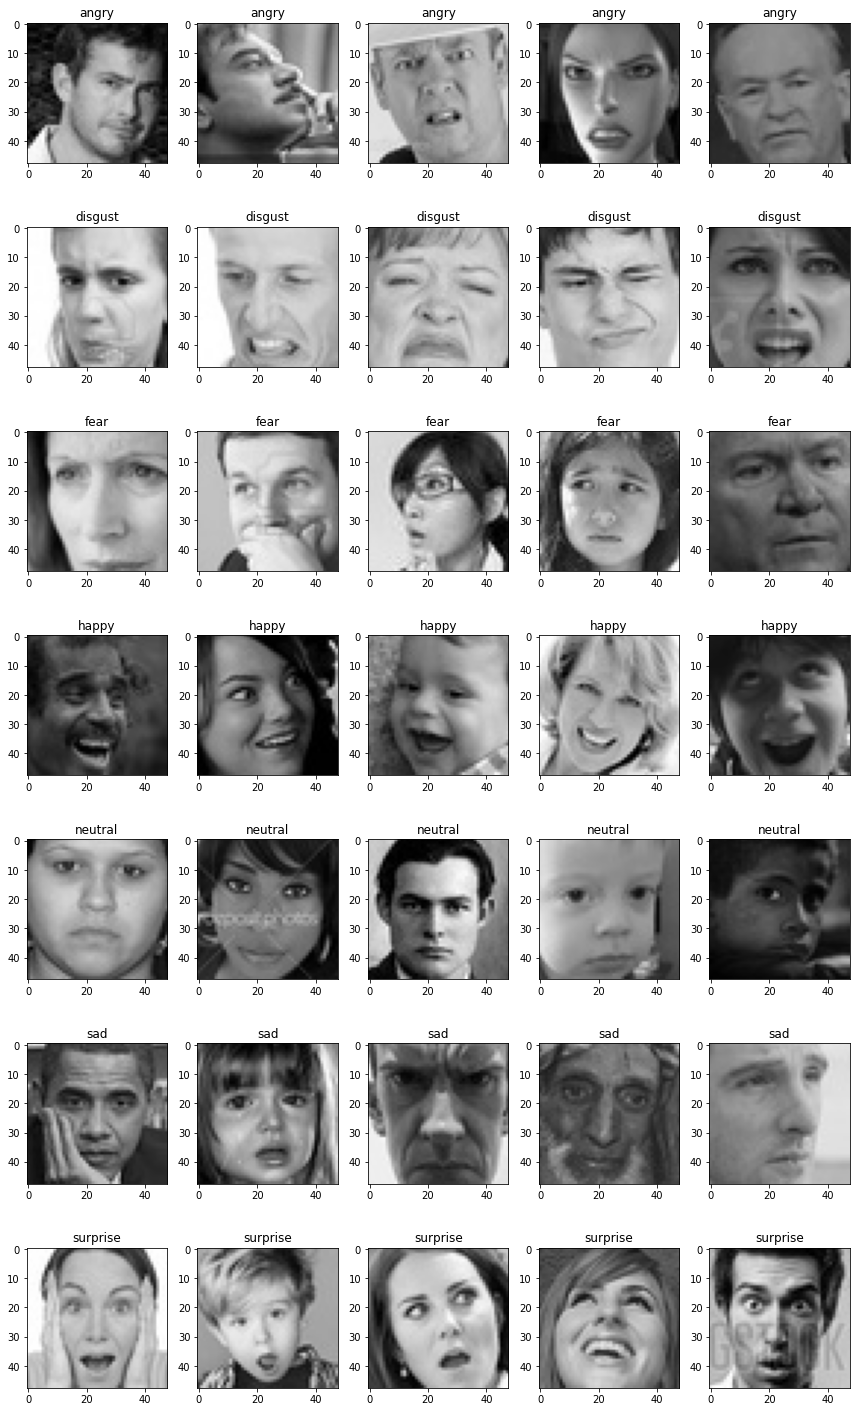

In [19]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_dataset_images(plt,img_size,dir):
    img_size = img_size
    plt.figure(0, figsize=(12,20))
    index = 0

    for emotion in os.listdir(dir):
        for i in range(1,6):
            index += 1
            plt.subplot(7,5,index)
            img = load_img(dir + emotion + "/" +os.listdir(dir + emotion)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")
            plt.title(f"{emotion}")

    plt.tight_layout()
    return plt

plot_dataset_images(plt,48,dataset_path).show()

As we can see the dataset is composed of 48 by 48 pixel images in grayscale mode. We should divide the whole datset in two different folders:
- training_dataset/
- testing_dataset/

We do this in order to have one set for training the neural network and one set containing images that the model has never seen, so we can test how accurate it is. The idea is to have 20% of the whole dataset reserved for testing and the remaining 80% for training.

## Data Augmentation

Deep learning models normally need a big datset in order to be properly trained, but since our CK+ dataset is not that large, we will be using data augmentation techniques in order to increase the amount of "data" by performing random transformations on the images contained in the original dataset and returning it for the training.

In reality we are not increasing the dataset per se, because we are not performing **data generation augmentation** or **data expansion augmentation**. Instead we are using what is called **in-place data augmentation**.

In this case we are using ImageDataGenerator from TensorFlow-Keras, which generates batches of tensor image data with real-time or so called in-place data augmentation. Here is how ImageDataGenerator generally works:

1. It accepts a batch of images used for training;
2. It then applies a series of random transformation to each image in the batch (for example random rotation, resizing, shearing, etc.);
3. It then replaces the original batch with the new created one;
4. Then we train the CNN on this randomly transformed batch.

In [20]:
# First the only data augmentation will be the horizontal flip, for further models I will add more complex transformation
training_datagen = ImageDataGenerator(horizontal_flip=True)
training_generator = training_datagen.flow_from_directory(
        '../../../datasets/kaggle_dataset_train/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

validation_datagen = ImageDataGenerator(horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        '../../../datasets/kaggle_dataset_test/',
        target_size=(48, 48),
        batch_size=32,
        class_mode="categorical",
        color_mode="grayscale",
        shuffle=True,
        )

Found 25839 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Neural Network Model

One important aspect for the project to work as expected is to choose the right neural network model.

For getting started we will use a simple CNN and maybe later experiment with other types of models.

In [21]:
# Initialising the CNN
model = Sequential()

# Convolutional Layer N.1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.3
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Convolutional Layer N.4
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Now we flatten the volume to pass it to the fully connected layers
model.add(Flatten())

# Now we create the first fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Now we create the second fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

# Now we create the output [7 is the number of classes]
# We use softmax since it's for multi-classification
model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_14 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_17 (Batc (None, 24, 24, 128)      

## Training

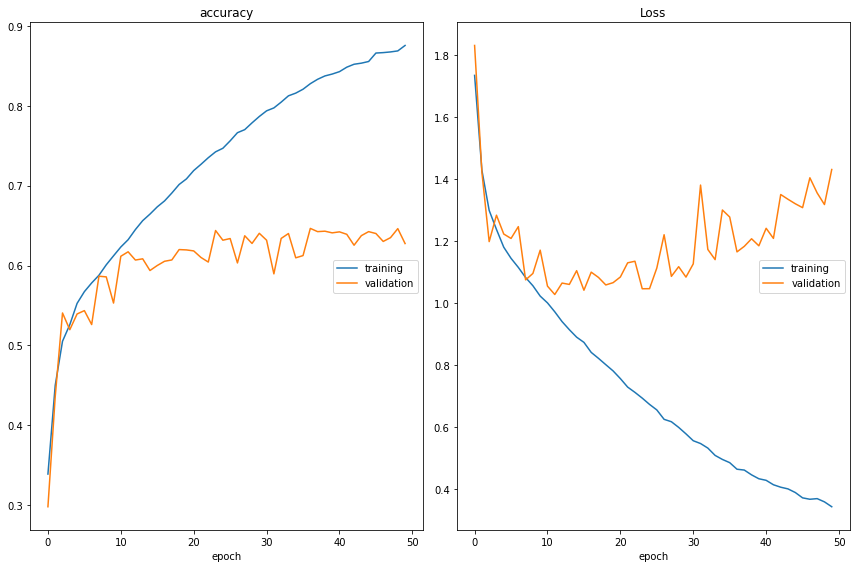

accuracy
	training         	 (min:    0.339, max:    0.876, cur:    0.876)
	validation       	 (min:    0.298, max:    0.646, cur:    0.628)
Loss
	training         	 (min:    0.343, max:    1.735, cur:    0.343)
	validation       	 (min:    1.028, max:    1.832, cur:    1.431)


In [22]:
# Optimizer [tweak for how much time training will take]
model.compile(optimizer=Adam(lr=0.0005), loss="categorical_crossentropy", metrics=["accuracy"])

# Setup how many epochs we want for each training and also how many steps per epoch
epochs = 50
steps_per_epoch = training_generator.n//training_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

callbacks = [PlotLossesKerasTF()]

history = model.fit(
    x=training_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Results

The initial results are not that promising, the model has 87% accuracy on the training set and only 62% on the validation set, so the model is overfitting.

### Save the Model

In [23]:
model.save("kaggle_model_gen1.h5")

# serialize the model to json
model_json = model.to_json()
# save the model architecture to JSON file
with open("kaggle_model_gen1.json", "w") as json_file:
    json_file.write(model_json)

model_yaml = model.to_yaml()
with open("kaggle_model_gen1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [ ]:
# Convert model to TensorFlowJS
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'tensorflowJS')